## Loan Amortization and Pricing
#### Explaining the loan amortization schedules and proposing a holistic approach for pricing

Risk-based loan pricing has been an important problem for financial institutions that provide loans to consumers. Traditional lenders such as commercial banks usually rely on customers' credit scores such as FICO and loan attributes such as term to decide whether to approve or decline the loan applications, and then based on the expected loss in each cohort to derive the interest rates.

The first part of the underwriting process is the so-called “acquisition”. Usually, based on the historical applications and default data, credit scoring models for application are built to assign a custom score to each application. For example, logistic regression, random forest, and XGBoost models etc are usually the typical models used in practice. In the absence of sufficient data for matured loans, survival models (such as Accelerated Failure Time models) can be effectively applied to derive a full life time probability of default estimate, and can also be used to generate a full curve of marginal probability of default in each payment period over the life cycle of the loan.

The second part of the underwriting process is the so-called “pricing”. So, after a customer's application is approved, how should we determine the interest rate? Of course, one would think of that a customer with higher probability of default should be assigned with a higher interest rate. But how to create the mapping from the probability of default to the optimal interest rate is a problem. 

One could use the historical loss rates and relate them to the PD custom scores bands to derive appropriate interest rates for various applicants. A more popular approach for pricing in industry practice is to develop a lifetime expected loss model to derive the lifetime expected loss estimates for different cohort of applications, and use them as inputs for the pricing model to determine the interest rates. 
The weakness of these pricing approaches – which rely on the segmentation methodology (e.g. by FICO bands or Term, or custom score bands) – is that it doesn’t provide a fully customized pricing for each applicant. Another weakness of the approach using EL as input for pricing is that the EL for each applicant actually depends on the interest rate, which is supposed to be an output of the pricing model. Using empirical losses of applications with various interest rates as inputs for pricing model, but not considering the impact of interest rates on the expected losses, seems not theoretically right, although this is frequently done in practice. 


A few fin-tech companies have employed the so called “Precision Pricing” approach (such as Earnest etc) to offer fully customized interest rates to customers based on their unique risk levels, without having to assign same rates for a lot of customers with different risk levels. Put in another way, the pricing rates can be continuous instead of discrete.

So, how to calculate a fully customized pricing rate for each applicant? Back to the basic principle: why would banks issue loans? A common sense principle for pricing is that: the expected interest income from the loan should at least cover the expected losses from the loan (including the underwriting cost should the loans be prepaid early), plus, a minimum target profit rate of return. 

The goal of this article is to propose an approach for pricing by following this principle that the expected interest income should cover the expected losses from the loan, such that a personalized pricing can be generated for each customer and the impact of interest rate on expected loss and income are considered at the same time. 

To explain this better, we need to first understand the loan amortization structure.


The structure of the article consists of three parts: 
(1) Explain the basics of a fixed payment loan structure; 
(2) Derive the expected interest income and expected losses; 
(3) Propose an approach for determining the optimal pricing; 
(4) Provide an implementation example of pricing given the curve of probability of default.

## Loan Amortization 

A loan can be amortized with fixed monthly payments or fixed principal payments. Here we only consider the "fixed monthly payments" amortization.

Assume the loan amount is $ A$, the annual interest rate is $r$, the term of loan is $T$-year, the number of payments per year is 12, then the monthly payment of the loan can be calculated by the following formula:
$$ p = \frac{A\frac{r}{12}}{1-(1+\frac{r}{12})^{-n}} $$
where $n=12T$ is the total number of payments.

This is calculated based on the equality between the loan amount and the present value of all future monthly payments:
$$ A = \frac{p}{1+\frac{r}{12}} + \frac{p}{(1+\frac{r}{12})^2} + ... + \frac{p}{(1+\frac{r}{12})^{n-1}} + \frac{p}{(1+\frac{r}{12})^{n}} $$

$$ A = \frac{p}{1+\frac{r}{12}} \frac {1-(\frac{1}{1+\frac{r}{12}})^{n}}{1-\frac{1}{1+\frac{r}{12}}} $$

The remaining principal balance after the t-th payment can be calculated as following:

$$ P_t = (A-\sum_{i=1}^{t}\frac{p}{(1+\frac{r}{12})^i})(1+\frac{r}{12})^t $$ 
$$ P_t = A(1+\frac{r}{12})^t - \frac{p((1+\frac{r}{12})^t-1)}{\frac{r}{12}} $$

The interest income from the t-th payment is:
$$ I_t = P_{t-1}\frac{r}{12} = (A\frac{r}{12}-p)(1+\frac{r}{12})^{t-1}+p $$
where $P_0 = A$.

The principal payment component in the t-th payment is then:
$$ PPM_t = p - I_t = (p-A\frac{r}{12})(1+\frac{r}{12})^{t-1}   $$


Cumulative Interest Income after t-th payment is:
$$ CI_t = \sum_{i=1}^{t}{I_i} $$
$$ CI_t = pt-(p-A\frac{r}{12}) \frac{(1+\frac{r}{12})^t-1}{\frac{r}{12}} $$

Below we show an example.

In [3]:
import numpy as np
import math

A = 360000.0
r = 0.04
T = 30
p = - np.pmt(r/12, T*12, A)
p

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: numpy.pmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.pmt instead (https://pypi.org/project/numpy-financial/).
  import sys


1718.6950636756337

In [4]:
p = A*r/12/(1-math.pow(1+r/12,-12*T))
p

1718.6950636756335

The interest payment and principal payment after the t-th month are calculated as follows.

In [5]:
import pandas as pd
df = pd.DataFrame(index = ['Month_'+str(t) for t in range(1,12*T+1)], columns = ['Month','Start_Principal','Payment','Interest_Pmt',
                                                                              'Principal_Pmt','End_Principal'])


In [6]:
df['Month'] = range(1,12*T+1)
df['Start_Principal'] = [A*math.pow(1+r/12,t)- p*(math.pow(1+r/12,t)-1)/(r/12) for t in range(0,12*T)]
df['End_Principal'] = [A*math.pow(1+r/12,t)- p*(math.pow(1+r/12,t)-1)/(r/12) for t in range(1,12*T+1)]
df['Payment'] = p
df['Interest_Pmt'] = df['Start_Principal']*r/12
df['Principal_Pmt']= df['Payment']-df['Interest_Pmt']
df

,Month,Start_Principal,Payment,Interest_Pmt,Principal_Pmt,End_Principal
Month_1,1,360000.000000,1718.695064,1200.000000,518.695064,3.594813e+05
Month_2,2,359481.304936,1718.695064,1198.271016,520.424047,3.589609e+05
Month_3,3,358960.880889,1718.695064,1196.536270,522.158794,3.584387e+05
Month_4,4,358438.722095,1718.695064,1194.795740,523.899323,3.579148e+05
Month_5,5,357914.822772,1718.695064,1193.049409,525.645654,3.573892e+05
...,...,...,...,...,...,...
Month_356,356,8508.204517,1718.695064,28.360682,1690.334382,6.817870e+03
Month_357,357,6817.870135,1718.695064,22.726234,1695.968830,5.121901e+03
Month_358,358,5121.901305,1718.695064,17.073004,1701.622059,3.420279e+03
Month_359,359,3420.279246,1718.695064,11.400931,1707.294133,1.712985e+03


Let's look at the composition of principal payment and interest payment in the monthly payment.

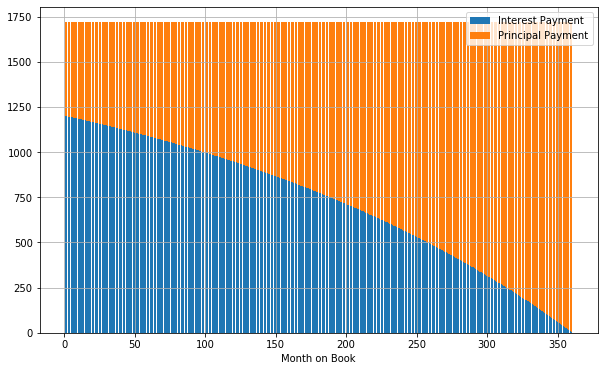

In [7]:
# Plot the Principal Payment and Interest Payment
from matplotlib import pyplot as plt
fig,ax = plt.subplots(figsize=(10,6))
plt.bar(df['Month'],df['Interest_Pmt'], label = 'Interest Payment')
plt.bar(df['Month'],df['Principal_Pmt'], bottom = df['Interest_Pmt'], label = 'Principal Payment')
plt.xlabel('Month on Book')
plt.legend()
plt.grid(True)

Let's look at the remaining principal balance after each month's payment, and the cumulative interest paid (which is the cumulative interest income collected by the bank).

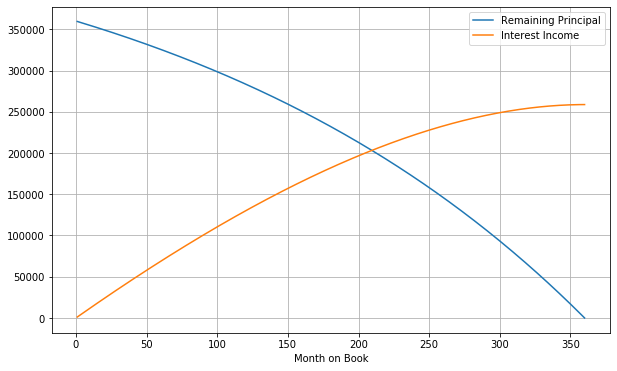

In [8]:
fig,ax = plt.subplots(figsize=(10,6))
plt.plot(df['Month'],df['End_Principal'], label = 'Remaining Principal')
plt.plot(df['Month'],df['Interest_Pmt'].cumsum(), label = 'Interest Income')
plt.xlabel('Month on Book')
plt.legend()
plt.grid(True)

Note that, if a borrower defaults, the bank's net loss is then the remaining principal balance minus the interest collected. Customers with different probability of default need to be assigned with different interest rates to compensate the potential losses if a default occurs.

## Probability of Default 

To accurately price the interest rate for a customer, we would need to have the probability of default estimate in each month over the life cycle of the loan.

The survival analysis is an effective tool that can be applied to estimate the survival curve for each loan applicant. 

$$ S(t) = P(t_e > t) = 1 - F(t) $$

where $t_e$ is the time of default.

Assume that the survival probabilities after each month $0,1,...,n$ are estimated as:

$$ 1, S(1), S(2), ...., S(n) $$


The marginal probability of default $f(t)$ within each month $1,...,n$ can be obtained by differencing the survival curve:
$$ 1-S(1), S(1)-S(2), ...,  S(n-1)-S(n) $$

The lifetime probability of default is then:
$$ \sum_{t=1}^{n}{f(t)} = 1-S(n) $$

Weibull distribution is one of the popular choices for describing the time to default distribution. Assume the survival curve for an applicant is:
$$ S(t) = \exp{-(t/a)^b} $$
where $a>0, b>0$.

In [9]:
def weibull_prob(t,a,b):
    S = np.exp(-np.power(t*1.0/a,b))
    f = S[0:-1]-S[1:]
    
    return S[1:],f

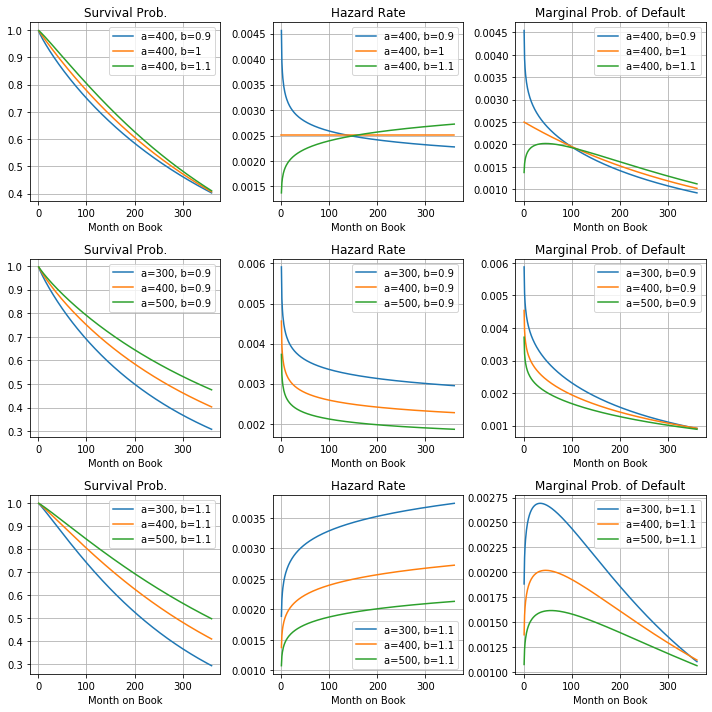

In [10]:
fig,axes = plt.subplots(3,3,figsize=(10,10))

t = np.array(range(0,361))

for i in range(3):
    if i==0:
        a = 400; b = 0.9; S1, f1 = weibull_prob(t,a,b); label1 = 'a=400, b=0.9'
        a = 400; b = 1; S2, f2 = weibull_prob(t,a,b);label2 = 'a=400, b=1'
        a = 400; b = 1.1; S3, f3 = weibull_prob(t,a,b); label3 = 'a=400, b=1.1'
    elif i==1:
        a = 300; b = 0.9; S1, f1 = weibull_prob(t,a,b); label1 = 'a=300, b=0.9'
        a = 400; b = 0.9; S2, f2 = weibull_prob(t,a,b); label2 = 'a=400, b=0.9'
        a = 500; b = 0.9; S3, f3 = weibull_prob(t,a,b); label3 = 'a=500, b=0.9'
    elif i==2:
        a = 300; b = 1.1; S1, f1 = weibull_prob(t,a,b); label1 = 'a=300, b=1.1'
        a = 400; b = 1.1; S2, f2 = weibull_prob(t,a,b); label2 = 'a=400, b=1.1'
        a = 500; b = 1.1; S3, f3 = weibull_prob(t,a,b); label3 = 'a=500, b=1.1'
    
    ax = axes[i,0]
    ax.plot(t[1:],S1, label = label1)
    ax.plot(t[1:],S2, label = label2)
    ax.plot(t[1:],S3, label = label3)
    ax.set_xlabel('Month on Book')
    ax.set_title('Survival Prob.')
    ax.legend()
    ax.grid(True)

    ax = axes[i,1]
    ax.plot(t[1:],f1/S1, label = label1)
    ax.plot(t[1:],f2/S2, label = label2)
    ax.plot(t[1:],f3/S3, label = label3)
    ax.set_xlabel('Month on Book')
    ax.set_title('Hazard Rate')
    ax.legend()
    ax.grid(True)
    
    ax = axes[i,2]
    ax.plot(t[1:],f1, label = label1)
    ax.plot(t[1:],f2, label = label2)
    ax.plot(t[1:],f3, label = label3)
    ax.set_xlabel('Month on Book')
    ax.set_title('Marginal Prob. of Default')
    ax.legend()
    ax.grid(True)
    
    
fig.tight_layout()

## Pricing

The goal of pricing is to find an interest rate such that the expected interest income is greater than the expected loss.

The expected loss (EL) can be calculated by the sum of monthly expected losses, which are obtained by multiplying the marginal probability of default in each month ($f(t)$) and the loss exposure (e.g. the monthly remaining principal balance):

$$ EL = \sum_{t=1}^{n}{f(t) P_{t-1}} $$

where $P_{t-1}$ is the loss exposure after $t-1$ payment periods if the default occurs in the t-th payment period.

The expected interest income can be calculated by the sum of monthly interest income.

There are two scenarios in calculating the expected interest income:

(1) If there is a default during the life cycle of the loan: The expected interest income is the sum of product between the marginal probability of default in each month ($f(t)$) and the cumulative interest income from the first $(t-1)$ payment period;

(2) If there is no default during the life cycle of the loan: The expected interest income is then the probability of non-default times the cumulative interest income from all payment periods.

Therefore, the expected interest income is:
$$ EI = \sum_{t=1}^{n}{f(t) CI_{t-1}} + (1-\sum_{t=1}^{n}{f(t)}) CI_{n} $$

In [11]:
import pandas as pd
T = 5
a = 400
b = 0.95
r = 0.05
df = pd.DataFrame(index = ['Month_'+str(t) for t in range(1,12*T+1)], columns = ['Month','Start_Principal','Payment','Interest_Pmt',
                                                                              'Principal_Pmt','End_Principal'])

p=A*r/12/(1-math.pow(1+r/12,-12*T))
df['Month'] = range(1,12*T+1)
df['Start_Principal'] = [A*math.pow(1+r/12,t)- p*(math.pow(1+r/12,t)-1)/(r/12) for t in range(0,12*T)]
df['End_Principal'] = [A*math.pow(1+r/12,t)- p*(math.pow(1+r/12,t)-1)/(r/12) for t in range(1,12*T+1)]
df['Payment'] = p
df['Interest_Pmt'] = df['Start_Principal']*r/12
df['Principal_Pmt']= df['Payment']-df['Interest_Pmt']

df['Survival_Prob'] = [np.exp(-np.power(t*1.0/a,b)) for t in  range(1,12*T+1)]
df['Marginal_PD'] = -df['Survival_Prob'].diff()
df.loc[df['Month']==1,'Marginal_PD']=1-df['Survival_Prob']
df['Cum_Interest'] = [p*t-(p-A*r/12)*(math.pow(1+r/12,t)-1)/(r/12) for t in range(1,12*T+1)]
df['Expected_Loss']= df['Marginal_PD']*df['Start_Principal']
df['Expected_Income']=0
df['Expected_Income'][0:-1] = np.array(df['Marginal_PD'][1:])*np.array(df['Cum_Interest'][0:-1])
df['Expected_Income'][-1]= df['Survival_Prob'][-1]*df['Cum_Interest'][-1]
df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Month,Start_Principal,Payment,Interest_Pmt,Principal_Pmt,End_Principal,Survival_Prob,Marginal_PD,Cum_Interest,Expected_Loss,Expected_Income
Month_1,1,360000.000000,6793.644112,1500.000000,5293.644112,354706.355888,0.996632,0.003368,1500.000000,1212.308729,4.691843
Month_2,2,354706.355888,6793.644112,1477.943150,5315.700962,349390.654926,0.993505,0.003128,2977.943150,1109.484351,9.045760
Month_3,3,349390.654926,6793.644112,1455.794396,5337.849716,344052.805210,0.990467,0.003038,4433.737545,1061.304298,13.200722
Month_4,4,344052.805210,6793.644112,1433.553355,5360.090757,338692.714453,0.987490,0.002977,5867.290900,1024.360459,17.197998
Month_5,5,338692.714453,6793.644112,1411.219644,5382.424468,333310.289984,0.984558,0.002931,7278.510544,992.764266,21.058387
Month_6,6,333310.289984,6793.644112,1388.792875,5404.851237,327905.438748,0.981665,0.002893,8667.303419,964.342522,24.794613
Month_7,7,327905.438748,6793.644112,1366.272661,5427.371450,322478.067297,0.978805,0.002861,10033.576080,938.041281,28.415359
Month_8,8,322478.067297,6793.644112,1343.658614,5449.985498,317028.081799,0.975973,0.002832,11377.234694,913.266624,31.926994
Month_9,9,317028.081799,6793.644112,1320.950341,5472.693771,311555.388028,0.973166,0.002806,12698.185035,889.649717,35.334426
Month_10,10,311555.388028,6793.644112,1298.147450,5495.496662,306059.891366,0.970384,0.002783,13996.332485,866.945226,38.641588


In [12]:
print("Profit of Loan in $ is:" + str(df['Expected_Income'].sum()-df['Expected_Loss'].sum()))
print("Profit of Loan in % is:" + str((df['Expected_Income'].sum()-df['Expected_Loss'].sum())/A))

Profit of Loan in $ is:14462.889059176603
Profit of Loan in % is:0.04017469183104612


The problem of pricing is to find a minimum interest rate $r$ such that 
$$ EI - EL >=0 $$

In [13]:
def net_income(interest_rate, term, survival_para1, survival_para2):
    r = interest_rate
    T = term
    a,b = survival_para1, survival_para2
    
    t = np.array(range(0,12*T+1))
    S, f = weibull_prob(t,a,b)
    A = 100
    p = A*r/12/(1-math.pow(1+r/12,-12*T))

    CI = [p*t-(p-A*r/12)*(math.pow(1+r/12,t)-1)/(r/12) for t in range(0,12*T+1)]

    Loss_Exp = [A*math.pow(1+r/12,t)-p*(math.pow(1+r/12,t)-1)/(r/12) for t in range(0,12*T)]

    EL = np.sum(f*Loss_Exp)

    EI = np.sum(f*CI[0:-1]) + S[-1]*CI[-1]
    
    return (EI-EL)/A

#net_income(0.0339, T, a, b)
    

In [27]:
import scipy.optimize
T = 30
a = 400
b = 0.95
optim_interest = scipy.optimize.brentq(lambda x: net_income(x, T, a,b), a= 0.0001,b=0.99999)

optim_interest

0.03114495404515457

In [28]:
net_income(optim_interest, T, a, b)

-6.892264536872972e-15

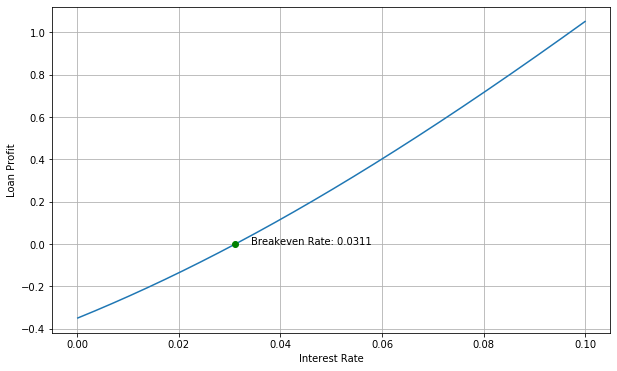

In [29]:
r = np.linspace(0.0001,0.1,1000)
y = [net_income(x, T,a,b) for x in r]
fig,ax = plt.subplots(figsize=(10,6))
plt.plot(r,y)
plt.grid(True)
plt.plot(optim_interest,net_income(optim_interest, T,a,b),'go')
plt.ylabel('Loan Profit')
plt.xlabel('Interest Rate')
plt.text(optim_interest*1.1,net_income(optim_interest, T,a,b), 'Breakeven Rate: '+'{0:0.4f}'.format(optim_interest));

## Pricing under discount rate

So far, we have not considered the "time value" aspect of the loss and interest cash flows. As a common sense, banks would prefer to collect the interest income as early as possible. Therefore, it makes more sense by discounting the future cashflows of both losses and interest income back to the present.

Let's assume that the discount rate is $r_d$, then the cumulative discounted losses become:
$$ DCL_t = \frac{P_t}{(1+\frac{r_d}{12})^t} = \frac{A(1+\frac{r}{12})^t - \frac{p((1+\frac{r}{12})^t-1)}{\frac{r}{12}}}{(1+\frac{r_d}{12})^t} $$
where $P_t$ is the remaining principal balance after the $t$-th payment.

The cumulative discounted interest income becomes:
$$ DCI_t = \sum_{i=1}^{t}{\frac{I_i}{(1+\frac{r_d}{12})^i}} $$
$$ = p \frac{1-(1+\frac{r_d}{12})^{-t}}{\frac{r_d}{12}}+ \frac{(A\frac{r}{12}-p)(1-(\frac{1+\frac{r}{12}}{1+\frac{r_d}{12}})^t)}{\frac{r_d-r}{12}} $$

Therefore, the expected discounted loss and the expected discounted income can be expressed as follows:
$$ EDL = \sum_{t=1}^{n}{f(t) DCL_{t-1}} $$

$$ EDI = \sum_{t=1}^{n}{f(t) DCI_{t-1}} + (1-\sum_{t=1}^{n}{f(t)}) DCI_{n} $$

In [17]:
def net_discounted_income(interest_rate, discount_rate, term, survival_para1, survival_para2):
    r = interest_rate
    rd = discount_rate
    
    T = term
    a,b = survival_para1, survival_para2
    
    t = np.array(range(0,12*T+1))
    S, f = weibull_prob(t,a,b)
    A = 100
    p = A*r/12/(1-math.pow(1+r/12,-12*T))

    DCI = [p*(1-math.pow(1+rd/12,-t))/(rd/12)+(A*r/12-p)*(1-math.pow((1+r/12)/(1+rd/12),t))/((rd-r)/12) for t in range(0,12*T+1)]

    Disc_Loss = [(A*math.pow(1+r/12,t)-p*(math.pow(1+r/12,t)-1)/(r/12))/math.pow(1+rd/12,t) for t in range(0,12*T)]

    EDL = np.sum(f*Disc_Loss)

    EDI = np.sum(f*DCI[0:-1]) + S[-1]*DCI[-1]
    
    return (EDI-EDL)/A

In [25]:
import pandas as pd
T = 30
a = 400
b = 0.95
r = 0.05
rd = 0.02
df = pd.DataFrame(index = ['Month_'+str(t) for t in range(1,12*T+1)], columns = ['Month','Start_Principal','Payment','Interest_Pmt',
                                                                              'Principal_Pmt','End_Principal'])

p=A*r/12/(1-math.pow(1+r/12,-12*T))
df['Month'] = range(1,12*T+1)
df['Start_Principal'] = [A*math.pow(1+r/12,t)- p*(math.pow(1+r/12,t)-1)/(r/12) for t in range(0,12*T)]
df['Discounted_Loss'] = [(A*math.pow(1+r/12,t)-p*(math.pow(1+r/12,t)-1)/(r/12))/math.pow(1+rd/12,t) for t in range(0,12*T)]
df['End_Principal'] = [A*math.pow(1+r/12,t)- p*(math.pow(1+r/12,t)-1)/(r/12) for t in range(1,12*T+1)]
df['Payment'] = p
df['Interest_Pmt'] = df['Start_Principal']*r/12
df['Principal_Pmt']= df['Payment']-df['Interest_Pmt']

df['Survival_Prob'] = [np.exp(-np.power(t*1.0/a,b)) for t in  range(1,12*T+1)]
df['Marginal_PD'] = -df['Survival_Prob'].diff()
df.loc[df['Month']==1,'Marginal_PD']=1-df['Survival_Prob']
df['Cum_Discounted_Interest'] = [p*(1-math.pow(1+rd/12,-t))/(rd/12)+(A*r/12-p)*(1-math.pow((1+r/12)/(1+rd/12),t))/((rd-r)/12) for t in range(1,12*T+1)]
df['Expected_Discounted_Loss']= df['Marginal_PD']*df['Discounted_Loss']

df['Expected_Discounted_Income']=0
df['Expected_Discounted_Income'][0:-1]= np.array(df['Marginal_PD'][1:])*np.array(df['Cum_Discounted_Interest'][0:-1])
df['Expected_Discounted_Income'][-1]= df['Survival_Prob'][-1]*df['Cum_Discounted_Interest'][-1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
df

,Month,Start_Principal,Payment,Interest_Pmt,Principal_Pmt,End_Principal,Discounted_Loss,Survival_Prob,Marginal_PD,Cum_Discounted_Interest,Expected_Discounted_Loss,Expected_Discounted_Income
Month_1,1,360000.000000,1932.557843,1500.000000,432.557843,359567.442157,360000.000000,0.996632,0.003368,1497.504160,1212.308729,4.684036
Month_2,2,359567.442157,1932.557843,1498.197676,434.360167,359133.081990,358969.160223,0.993505,0.003128,2990.720300,1122.817957,9.084571
Month_3,3,359133.081990,1932.557843,1496.387842,436.170001,358696.911989,357938.957856,0.990467,0.003038,4479.651074,1087.270506,13.337422
Month_4,4,358696.911989,1932.557843,1494.570467,437.987376,358258.924613,356909.389146,0.987490,0.002977,5964.299115,1062.638816,17.482345
Month_5,5,358258.924613,1932.557843,1492.745519,439.812324,357819.112289,355880.450343,0.984558,0.002931,7444.667045,1043.144357,21.539116
...,...,...,...,...,...,...,...,...,...,...,...,...
Month_356,356,9543.168933,1932.557843,39.763204,1892.794639,7650.374294,5283.831225,0.408526,0.000977,271373.767759,5.163113,264.503914
Month_357,357,7650.374294,1932.557843,31.876560,1900.681283,5749.693011,4228.786771,0.407551,0.000975,271391.358386,4.121735,263.853036
Month_358,358,5749.693011,1932.557843,23.957054,1908.600789,3841.092223,3172.886518,0.406579,0.000972,271404.556750,3.084755,263.199690
Month_359,359,3841.092223,1932.557843,16.004551,1916.553292,1924.538931,2116.125374,0.405609,0.000970,271413.359268,2.052153,262.543899


In [23]:
import scipy.optimize
T = 30
a = 400
b = 0.95
rd = 0.02
optim_interest = scipy.optimize.brentq(lambda x: net_discounted_income(x, rd, T, a,b), a= 0.0001,b=0.99999)

optim_interest

0.03140261876828273

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Breakeven Interest Rate: 0.0313 When r_d = 0.01
Breakeven Interest Rate: 0.0318 When r_d = 0.05
Breakeven Interest Rate: 0.0324 When r_d = 0.1


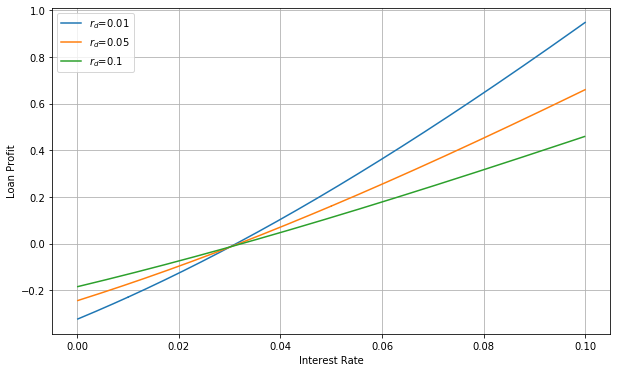

In [30]:
r = np.linspace(0.0001,0.1,1000)
y1 = [net_discounted_income(x, 0.01, T,a,b) for x in r]
y2 = [net_discounted_income(x, 0.05, T,a,b) for x in r]
y3 = [net_discounted_income(x, 0.1, T,a,b) for x in r]
fig,ax = plt.subplots(figsize=(10,6))
plt.plot(r,y1,label='$r_d$=0.01')
plt.plot(r,y2,label='$r_d$=0.05')
plt.plot(r,y3,label='$r_d$=0.1')
plt.legend()
plt.grid(True)
plt.ylabel('Loan Profit')
plt.xlabel('Interest Rate');
for rd in [0.01,0.05,0.1]:
    optim_interest = scipy.optimize.brentq(lambda x: net_discounted_income(x, rd, T, a,b), a= 0.0001,b=0.99999)
    print("Breakeven Interest Rate: " + '{0:1.4f}'.format(optim_interest) + ' When r_d = '+str(rd))

We can see that the impact of the discount rate on the pricing is very minor.

## Final Thoughts

So far, we have proposed a more personalized approach for pricing by considering the expected loss and expected interest income at the same time. The input of the pricing model is the survival curve or probability of default curve, the term information, and an assumption of discount rate (which seems have minor impact). The output of the pricing model is a breakeven interest rate. 

An advantage of this pricing approach is that it does not require estimating expected loss first (which sounds theoretically incorrect since the expected loss would depend on the interest rate). In addition, it provides a fully customized pricing rate for each application by using inputs from the probability of default curve. A pre-requisite of this approach is the monthly probability of default curve, which is a natural output from survival analysis approaches, but would be difficult to obtain for the usual fixed-period probability of default custom score models.

Note that the prepayment risk and underwriting cost are not considered yet. When a loan is prepaid, a pricing logic is that the collected interest income should cover the underwriting cost. In addition, recoveries are not considered as well. This will be left for future research.
